In [1]:
import os
from PIL import Image, ImageFile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Paths to your image directories
ImageFile.LOAD_TRUNCATED_IMAGES = True
fractured_dir = r"C:\Users\ydvha\OneDrive\Documents\bone_fracture_detection\bone_fracture_detection\images\Fractured"
non_fractured_dir = r"C:\Users\ydvha\OneDrive\Documents\bone_fracture_detection\bone_fracture_detection\images\Non_fractured"

# Function to load images and labels
def load_images(image_dir, label):
    images = []
    labels = []
    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert('RGB')  # Convert to RGB if needed
        img = img.resize((224, 224))  # Resize all images to 224x224
        img_array = np.array(img, dtype=np.float32) / 255.0 # Normalize the images to [0, 1]
        images.append(img_array)
        labels.append(label)
    return images, labels

In [3]:
# Load fractured images
fractured_images, fractured_labels = load_images(fractured_dir, 1)


In [4]:
# Load non-fractured images
non_fractured_images, non_fractured_labels = load_images(non_fractured_dir, 0)


In [5]:
import random

# Calculate the duplication factor
current_number_of_fractured_images = len(fractured_images)
desired_number_of_fractured_images = 4000  

# Determine how many times to duplicate
duplication_factor = desired_number_of_fractured_images // current_number_of_fractured_images
duplicated_fractured_images = fractured_images * duplication_factor

# Calculate how many additional images are needed
additional_images_needed = desired_number_of_fractured_images - len(duplicated_fractured_images)

# Use random.choices to select additional images
if additional_images_needed > 0:
    duplicated_fractured_images.extend(random.choices(fractured_images, k=additional_images_needed))

# Print the number of fractured images after duplication
print(f"Number of fractured images after duplication: {len(duplicated_fractured_images)}")

# Combine duplicated fractured images with non-fractured images
X = np.array(duplicated_fractured_images + non_fractured_images)
y = np.array([1] * len(duplicated_fractured_images) + [0] * len(non_fractured_images))



Number of fractured images after duplication: 4000


In [6]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Summary of the dataset
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

Training samples: 5892, Validation samples: 1474


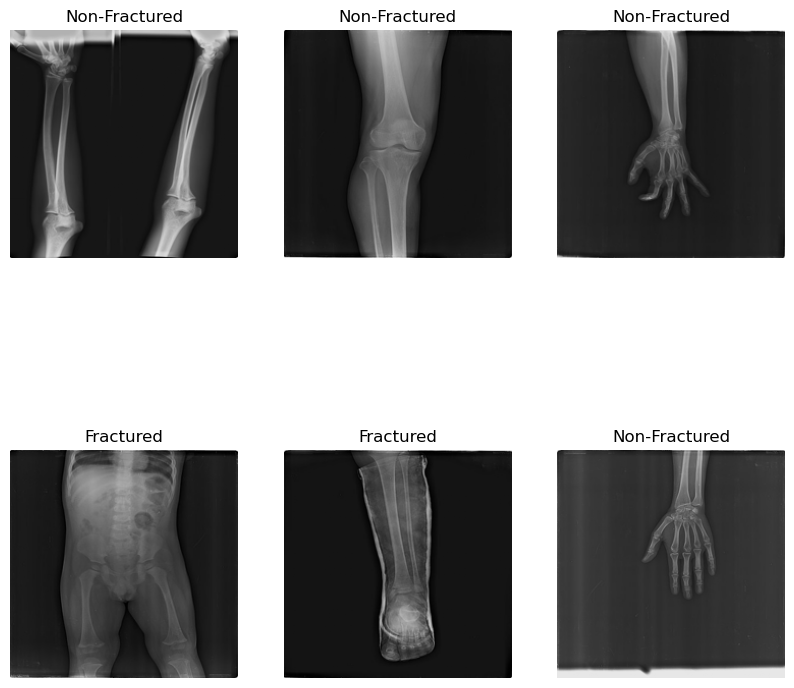

In [7]:
# Display a few samples from the dataset
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title('Fractured' if y_train[i] == 1 else 'Non-Fractured')
    plt.axis('off')
plt.show()

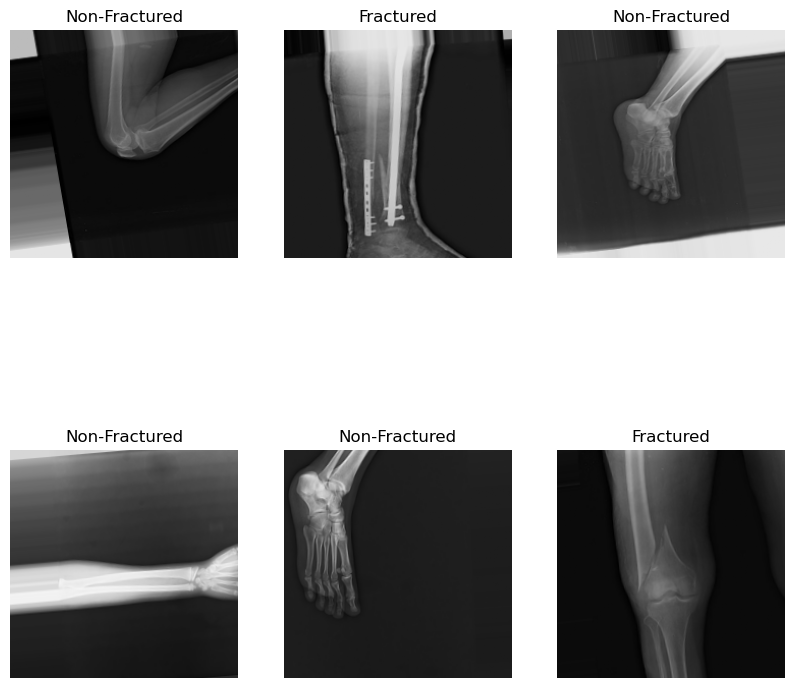

In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
datagen.fit(X_train)

# Example: display augmented images
augmented_images = next(datagen.flow(X_train, y_train, batch_size=6))

plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[0][i])
    plt.title('Fractured' if augmented_images[1][i] == 1 else 'Non-Fractured')
    plt.axis('off')
plt.show()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

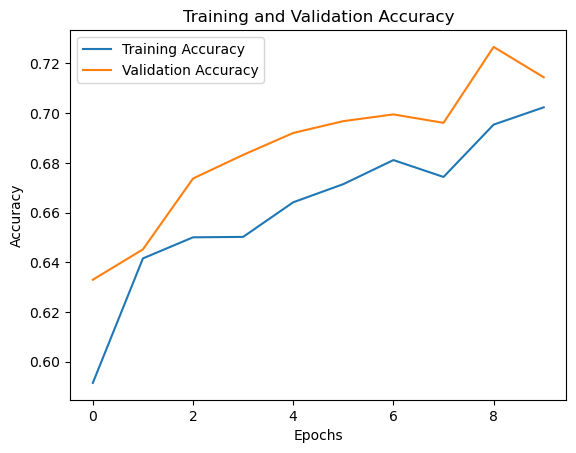

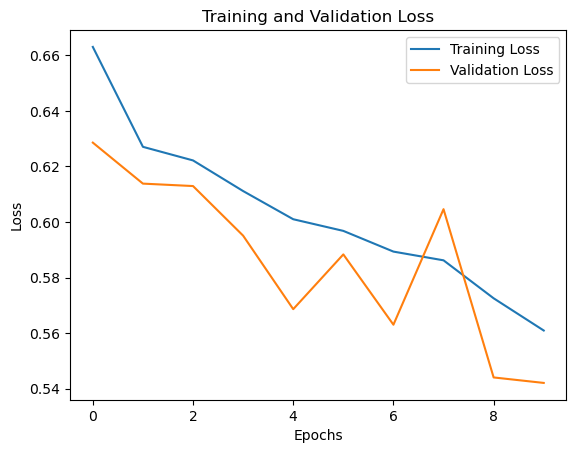

47/47 [==============================] - 18s 383ms/step - loss: 0.5420 - accuracy: 0.7144
Validation Accuracy: 0.7144


In [9]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define the CNN Model
model = models.Sequential()

# First Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flattening Layer
model.add(layers.Flatten())

# Fully Connected Layer
model.add(layers.Dense(128, activation='relu'))

# Output Layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

# Train the Model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=10)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Save the Model
model.save('bone_fracture_detection_model.h5')
